In [1]:
import os
os.getcwd()
os.chdir('/home/chtung/project_MC')

import numpy as np
import time
from tqdm import tqdm, trange
from WLM import WLChain
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat

<Figure size 1152x1152 with 0 Axes>

In [2]:
## Chain parameters
# Coordinate of C atoms in each unit
# unit_C = load('b_c.dat')';
unit_C = np.zeros((3,1))

# Degree of polymerization
N_backbone = 5000

# Chain stiffness (placeholder)
a_backbone = 1

# Unit persistence
lambda_backbone = 1

# Call WLChain class
chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
chain.apply_SA = 0
chain.d_exc = 0.1
chain.f = 0.0


In [3]:
kappa_list = np.array([5,15,45,135])
epsilon_list = [0]
parameters_list = []
for kappa in kappa_list:
    for epsilon in epsilon_list:
        parameters_list.append([kappa, epsilon])

In [4]:
kappa_list

array([  5,  15,  45, 135])

In [5]:
def eval_corr(kappa, epsilon, chain, n_sample = 20, n_merge = 4, rayleigh=False):
    ## generate spectra of three different grids
    corr_list = []
    d = np.ceil(10**(np.arange(64)/8)).astype('int')
    d = d[d<chain.N]

    for i, grid in enumerate(['SC','RB','RT']):
        print(grid)
        corr = np.zeros(len(d))
        for j in range(n_sample):
            # chain = WLChain(N_backbone,a_backbone,lambda_backbone,unit_C)
            chain.grid = grid
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.f = 0.0
            chain.kappa = kappa
            chain.epsilon = epsilon

            chain.chain_grid()
            d, corr_j = chain.corr_o()

            corr = corr + corr_j
        corr = corr/n_sample
        corr_list.append(corr)

    if rayleigh:
        print('KP')
        corr = np.zeros(len(d))
        chain.a = kappa
        for j in range(n_sample):
            
            chain.apply_SA = 0
            chain.d_exc = 0.1
            chain.chain()
            d, corr_j = chain.corr_o()

            corr = corr + corr_j
        corr = corr/n_sample
        corr_list.append(corr)

    return np.array(corr_list)

In [11]:
corr_list_param = []
d = np.ceil(10**(np.arange(64)/8)).astype('int')
d = d[d<N_backbone]
for j, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)

    corr_list_grid = eval_corr(kappa, epsilon, chain, n_sample = 8, n_merge = 1, rayleigh=True)
    corr_list_param.append(corr_list_grid)
    

[5, 0]
SC
RB
RT
KP
[15, 0]
SC
RB
RT
KP
[45, 0]
SC
RB
RT
KP
[135, 0]
SC
RB
RT
KP


In [7]:
corr_list_param[0].shape

(4, 30)

[5, 0]
[15, 0]
[45, 0]
[135, 0]


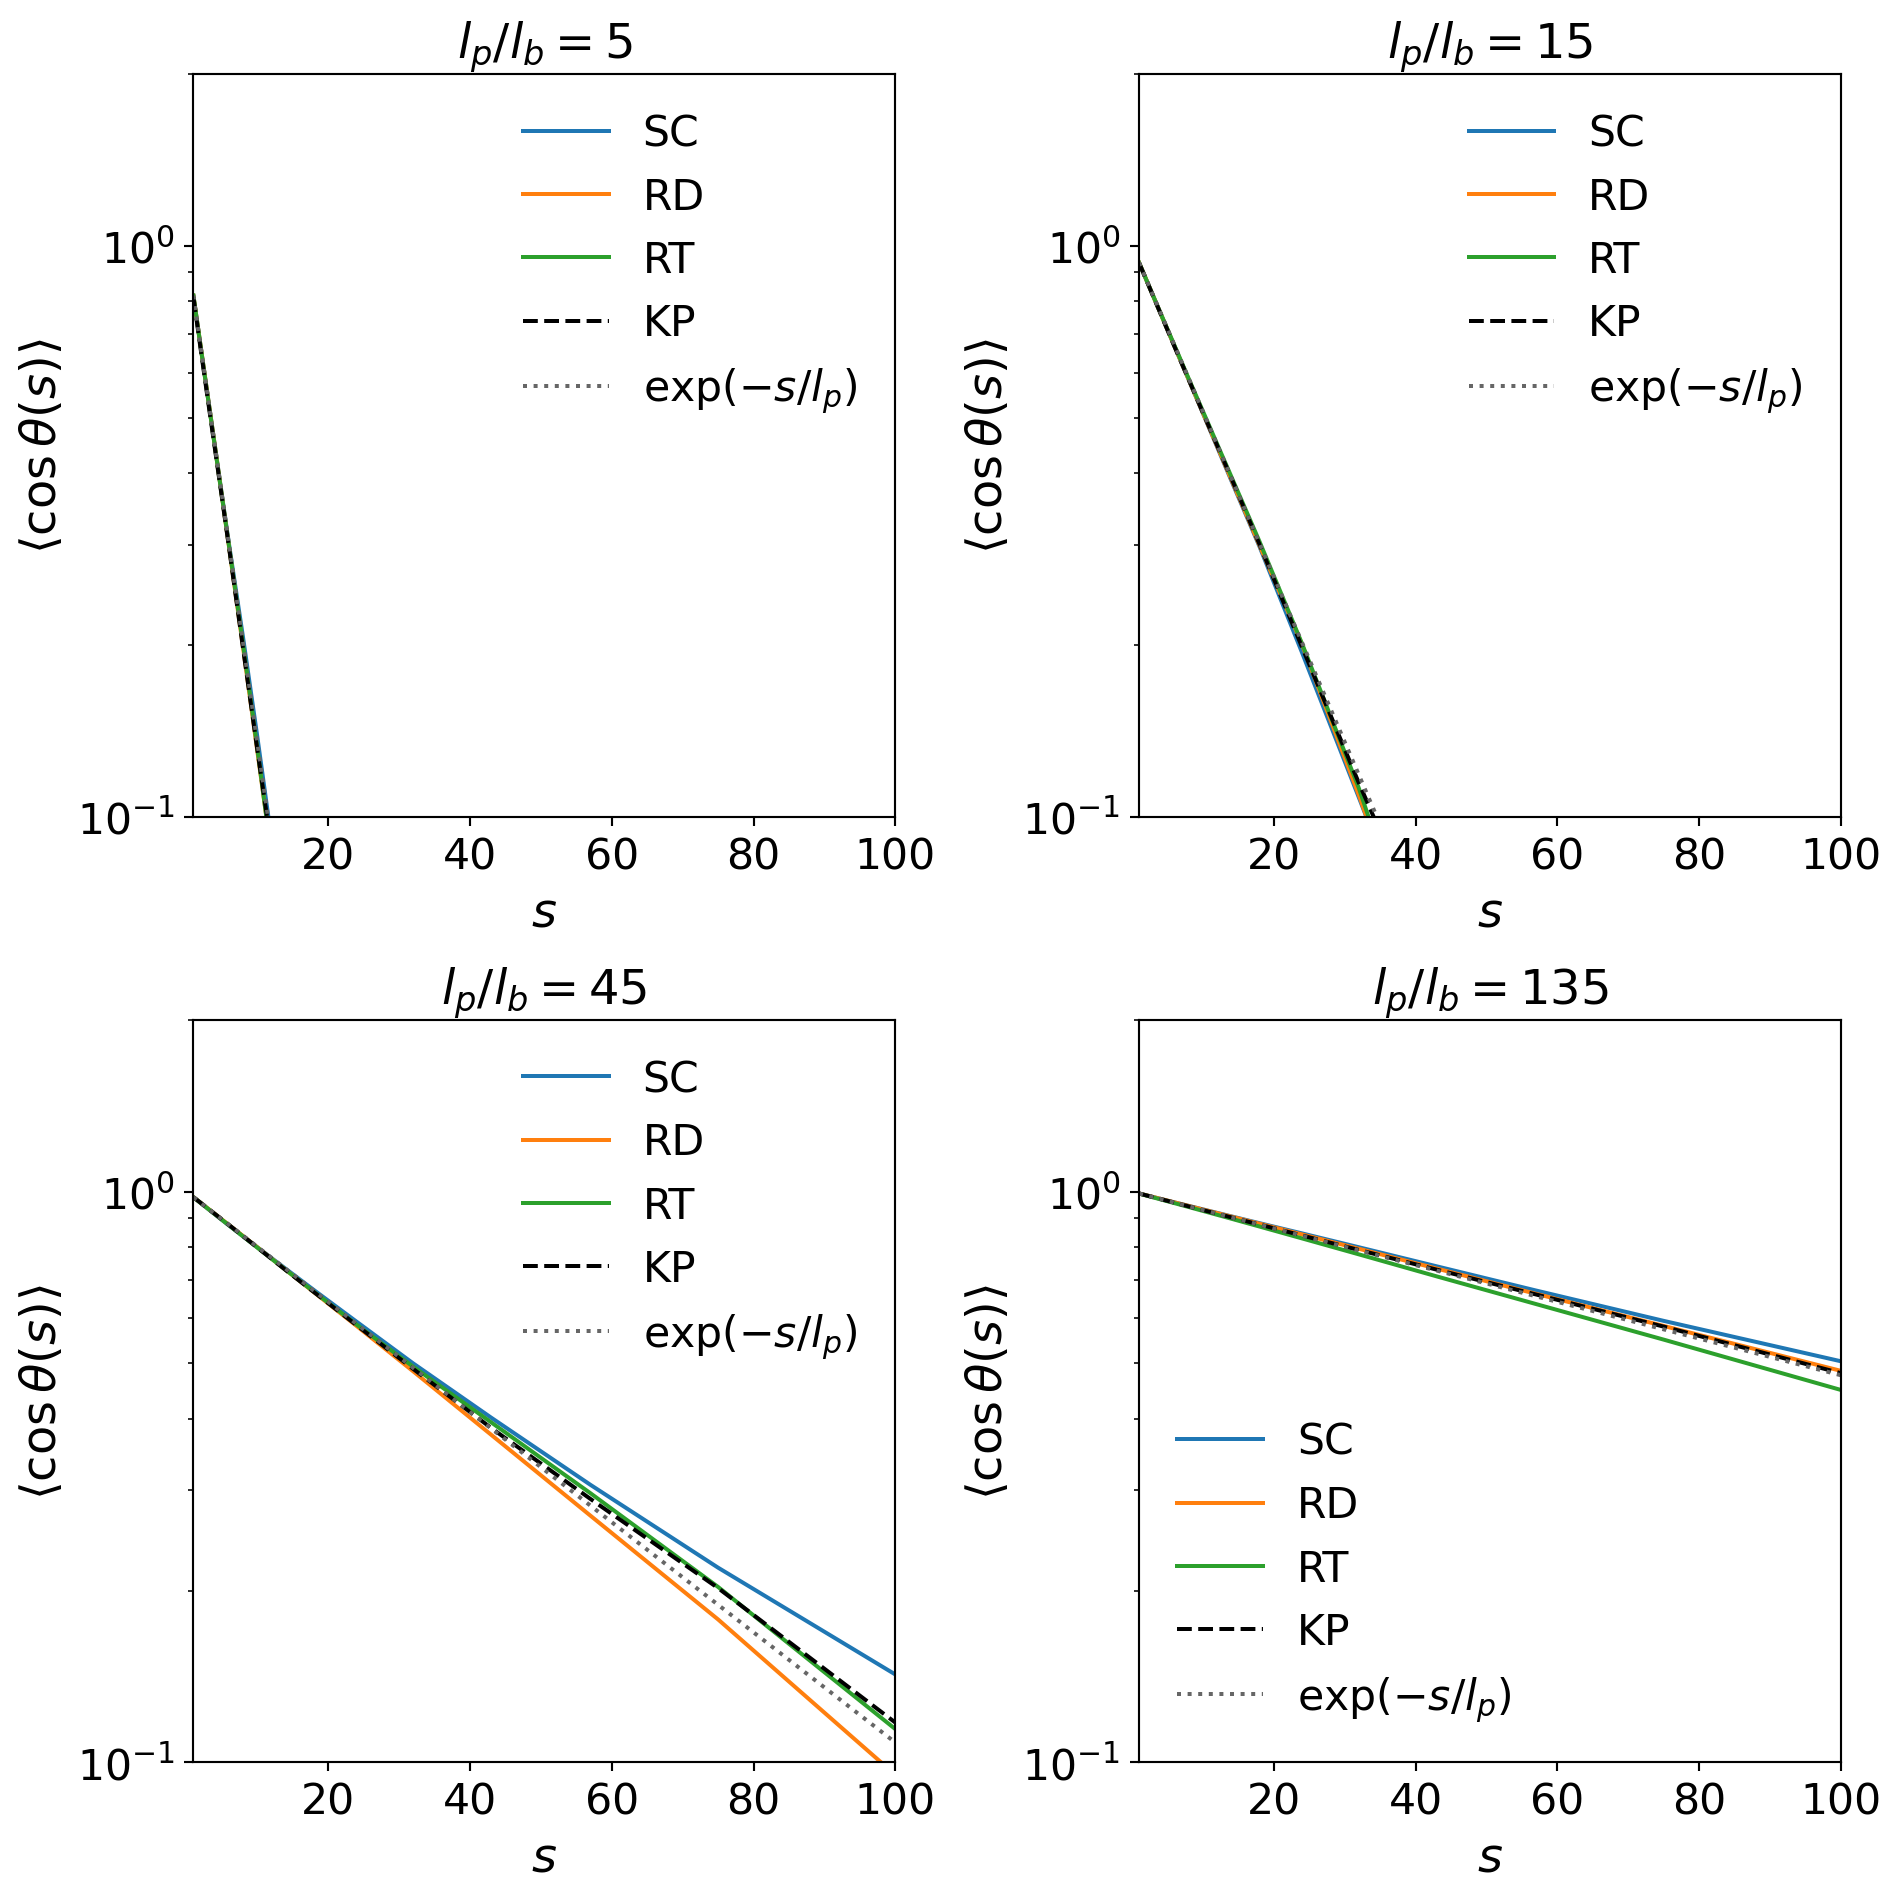

In [10]:
fig = plt.figure(figsize=(10, 10),dpi=192)

for j, params in enumerate(parameters_list):
    kappa = params[0]
    epsilon = params[1]
    print(params)
    
    ax = fig.add_subplot(2,2,j+1)
    ax.set_title(r'$l_p/l_b = {}$'.format(kappa),fontsize=18)
    for i, grid in enumerate(['SC','RD','RT']):
        ax.plot(d,corr_list_param[j][i], label=grid)
    ax.plot(d,corr_list_param[j][3], '--', label='KP', color='k')
    ax.plot(d, np.exp(-d/kappa), ':', color='#666666', label=r'$\exp(-s/l_p)$')
    
    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend(fontsize=16, frameon=False)
    ax.set_xlim([1,100])
    ax.set_ylim([1e-1,2])
    ax.set_xlabel(r'$s$',fontsize=18)
    ax.set_ylabel(r'$\langle \cos\theta(s) \rangle$',fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()


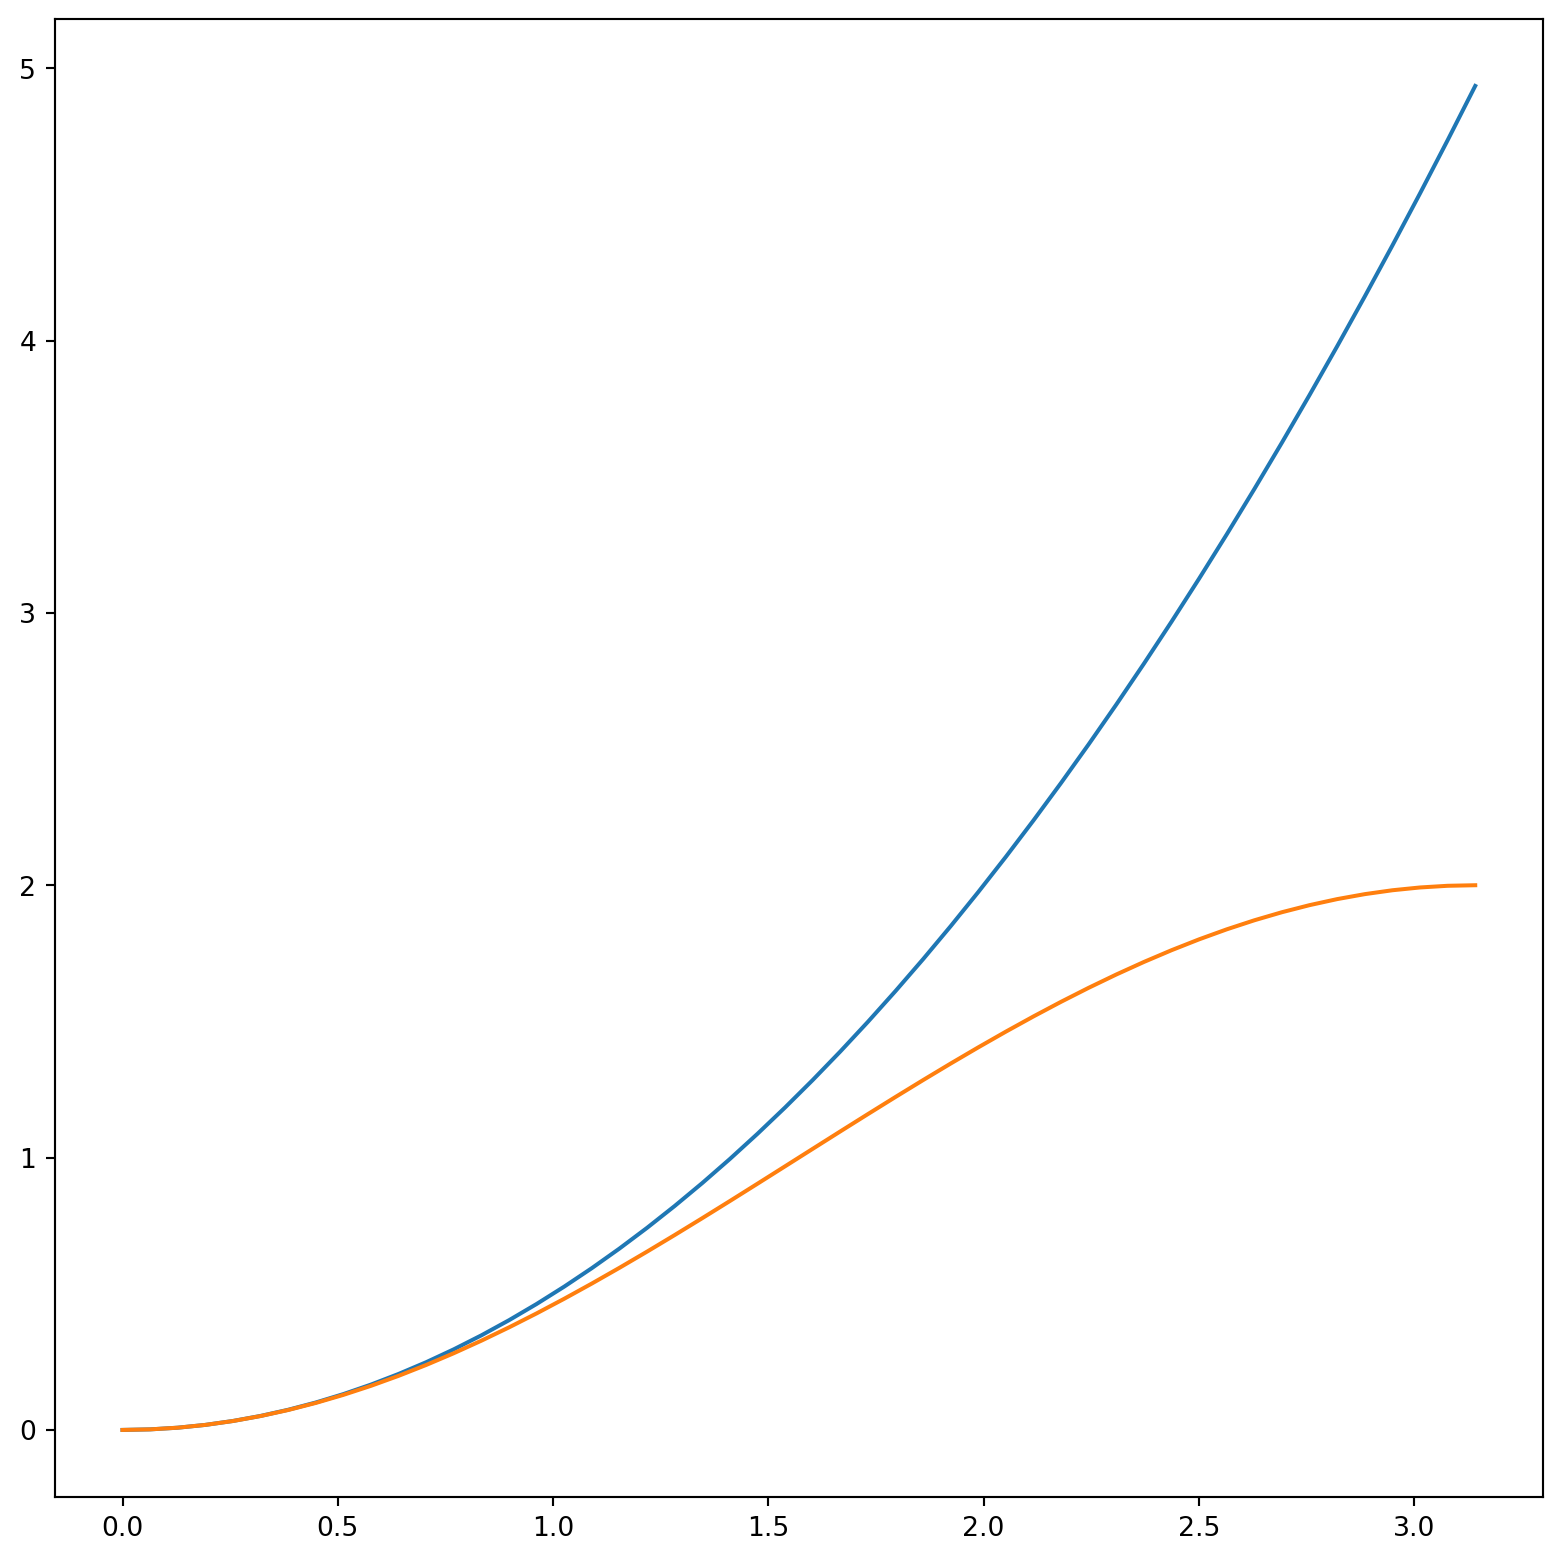

In [9]:
theta = np.linspace(0,np.pi)
fig = plt.figure(figsize=(10, 10),dpi=192)
ax = fig.add_subplot(1,1,1)
ax.plot(theta, theta**2/2)
ax.plot(theta, 1-np.cos(theta))